# LEPL1106, Devoir 7 : DFT

## 0) Introduction et objectifs

Votre artiste préféré a entendu parler d'une autre méthode afin d'appliquer un filtre sur son signal audio. Pour l'aider, votre artiste favori vous demande d'appliquer un filtre sur des signaux audio mais cette fois-ci en utilisant une technique bien précise ! On compte sur vous pour l'aider !*

Pour ce devoir, nous allons donc nous intéresser au filtrage de signaux audio grâce à la Tranformée de Fourier. Comme vous le savez, il n'est pas possible de représenter numériquement un signal continu, celui-ci a forcément dû être échantillonné (avec une fréquence d'échantillonnage notée `fech` par la suite). Toutefois, l'objectif de ce devoir est bien de manipuler le concept de filtrage et non celui d'échantillonnage, c'est pourquoi nous vous guiderons tout au long de ce notebook ;-)

Pour créer, stocker, et opérer sur les signaux, on utilisera le package [`NumPy`](http://www.numpy.org/) de Python. Pour manipuler les systèmes, on utilisera le package [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html).

In [152]:
# En cas d'erreur avec scipy, essayez de décommenter la ligne suivante pour mettre à jour le package. 
# Nous vous conseillons une version de scipy supérieure à 1.3.0

#!pip install -U scipy

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
import time

import scipy
print(scipy.__version__) # conseil: supérieure à 1.3.0

1.9.1


## 1) Consignes

### Evaluation

Les critères et modalités d'évaluation sont repris ci-dessous :

- *Respect consignes (1 point)* : Les fonctions ont un docstring et les informations importantes sont présentes en commentaire.
- *Objectifs du devoir atteints (8 points)* : Les fonctions soumises remplissent les objectifs du devoir et passent avec succès des tests simples, moyens et avancé.
- *Forme des figures (1 points)* : Les figures sont complètes; lisibles et compréhensibles. Les éléments suivants sont en outre présents : titre de la figure, labels des axes et unités, absence de fautes d'orthographe (majuscules aux noms propres incluses, e.g., Fourier).

### Deadline 

Le vendredi 26 avril à 20h00. Aucune extension n'est possible, prenez vos dispositions pour soumettre à temps, d'autant plus qu'**il est possible de faire seulement 5 soumissions par heure** (pour ne pas surcharger le serveur). Le debugging doit donc se faire via le Notebook.

### Précision
La remise par deux est autorisée et même encouragée pour peu que

- les deux étudiants soient membres du même groupe de TP ;
- les deux étudiants soient inscrits dans la même team sur la plateforme INGInious.

Questions sur le devoir à adresser au forum des Devoirs (sur Moodle), à votre tuteur/tutrice ou à melanie.ghislain@uclouvain.be.

Bon travail à toutes et à tous !

L'objectif principal de ce devoir est de démontrer qu'il est possible de calculer la sortie d'un filtre de plusieurs manières différentes et de le comparer à notre précédente version du calcul d'output d'un filtre par la convolution classique. En particulier, nous nous concentrerons sur l'utilisation de filtres Butterworth, Chebyshev I et Chebyshev II pour le traitement de signaux audio. Nous allons tester une méthode qui s'appelle "overlap-add" afin de calculer l'output d'un filtre.

## Conception du filtre

La fonction create_filter a pour objectif de concevoir et d'appliquer un filtre IIR (Infinite Impulse Response) sur un signal donné. Vous utiliserez les filtres Butterworth, Chebyshev I et Chebyshev II. Vous pouvez jouer avec les paramètres de cette fonction lors de son appel mais vous ne devez pas en modifier le code principal. La fonction permet également de choisir entre un filtre passe-bas, passe-haut ou passe-bande. Assurez-vous de manipuler correctement les fréquences de coupure et d'observer les effets de ces filtres sur un signal donné.

La fonction `create_filter(filterName,M,cutoff,fech, typeF)` conçoit le filtre IIR choisi (spécifié par l'argument `filterName`). `filterName` indiquant le nom du filtre à concevoir et prend ses valeurs dans {'Butterworth','ChebyshevI','ChebyshevII'}. La fonction peut donc être appelée avec chacune de ces différentes valeurs. L'argument `typeF` est un string indiquant le type de filtre à concevoir. Il prend ses valeurs dans {'lowpass','highpass','bandpass'}. L'argument `M` est un entier strictement positif correspondant à la longueur du filtre à concevoir (càd l'ordre du filtre + 1). Vous pourrez par la suite tester différentes valeurs de ce paramètre. Finalement, l'argument `cutoff` est un scalaire ou un vecteur (`numpy array`) de longueur $2$. Il s'agit de la fréquence de coupure du filtre de votre filtre par rapport à `fs`. Si le filtre est passe-bas ou passe-haut, cette fréquence est un scalaire. Si le filtre est passe-bande, il s'agit d'un vecteur de longueur $2$.

La fonction renvoye trois vecteurs (`numpy array`) : ``he`` qui est la réponse impulsionnelle du filtre ainsi que `a` et `b` qui sont les coefficients des polynomes de la fonction de transfert du filtre en fréquentiel.

In [153]:
def create_filter(filterName, M, cutoff, fech, typeF='lowpass'):
    # Code pour concevoir le filtre
    if filterName == "Butterworth":
        b, a = signal.butter(M-1, cutoff, typeF, analog=False, fs=fech)
    elif filterName == "ChebyshevI":
        b, a = signal.cheby1(M-1, 3, cutoff, typeF, analog=False, fs=fech)
    elif filterName == "ChebyshevII":
        b, a = signal.cheby2(M-1, 20, cutoff, typeF, analog=False, fs=fech)
    filterSys = signal.dlti(b,a)
    th, he = signal.dimpulse(filterSys)
    
    return np.reshape(he, np.size(he)), b,a

filterType = "Butterworth" # Concevoir un filtre Butterworth
filterOrder = 3  # Choisir un ordre de filtre approprié
cutoffFrequency = 150  # Choisir une fréquence de coupure appropriée
samplingFrequency = 1000  # Choisir une fréquence d'échantillonnage appropriée

he, b, a = create_filter(filterType, filterOrder, cutoffFrequency, samplingFrequency, 'lowpass')

## Application du filtre

Dans le domaine du traitement de signal, l'évaluation de la réponse fréquentielle d'un filtre est essentielle pour comprendre son comportement dans différentes gammes de fréquences. Une méthode courante pour obtenir cette réponse en fréquence consiste à utiliser la transformée de Fourier discrète (DFT), souvent calculée efficacement à l'aide de l'algorithme de la transformée de Fourier rapide (FFT). Cependant, il est important de noter que le calcul de la FFT du signal d'entrée peut être une opération coûteuse en termes de temps de calcul, en particulier pour des signaux de grande taille. Cela est dû au fait que la FFT nécessite d'examiner l'intégralité du signal dans le domaine temporel. Pour atténuer cet impact sur les performances, des techniques telles que la segmentation du signal ou l'utilisation d'algorithmes efficaces de calcul de la FFT peuvent être employées. Ces méthodes permettent de réduire le temps de calcul tout en préservant la précision de l'estimation de la réponse fréquentielle du filtre, ce qui est crucial dans de nombreuses applications de traitement de signal et de systèmes.

Le but de la méthode "overlap-add" est de filtrer un signal de manière efficace en utilisant la convolution rapide (FFT) tout en minimisant les effets de bord, souvent rencontrés lors de la convolution de signaux à l'aide de noyaux de filtre de grande taille. Cette méthode est largement utilisée dans le domaine du traitement de signal pour filtrer des signaux de grande taille de manière efficace et rapide. La stratégie utilisée dans la méthode "overlap-add" consiste à diviser le signal d'entrée en segments de taille fixe, `segmentSize`. Pour augmenter l'efficacité, ces segments peuvent se chevaucher les uns avec les autres pour garantir que chaque échantillon du signal d'entrée est pris en compte dans au moins un segment. Et ensuite cette méthode applique la convolution (filtrage) à chaque segment individuellement en utilisant la convolution rapide (FFT). Ensuite, les segments filtrés sont ajoutés ensemble en prenant en compte les zones de chevauchement, ce qui minimise les effets de bord et produit le signal de sortie filtré.

Il vous est maintenant demandé de compléter la fonction `applyFilter(inputSignal, he, segmentSize, overlap)` qui prend en argument le paramètre `he` étant la réponse impulsionnelle (`numpy array`) du filtre que l'on veut appliquer sur le signal d'entrée `inputSignal` ainsi que `segmentSize` correspondant à la taille des différents segments par lesquels on veut diviser le signal d'entrée. Cette fonction doit renvoyer l'output du filtre calculé par la FFT grâce à la méthode "overlap-add". Le paramètre `overlap` détermine le nombre de sample qui appartiendront à deux segments en même temps, le partie qui s'"overlap".

Pour l'implémenter, calculez d'abord le nombre de segments dont vous avez besoin pour couvrir l'entièreté du signal d'entrée `inputSignal`. Vous devez être sûr que tout soit couvert et que le dernier segment puisse être plus petit que `segmentSize`. Ensuite initialisez un tableau `filtered_signal` avec la même forme et le même type de données que le signal d'entrée (inputSignal) `float64`. Ce tableau contiendra la sortie filtrée. En commençant une boucle sur chaque segment du signal d'entrée, calculez les indices de début et de fin du segment actuel, en veillant à ce que l'indice de fin ne dépasse pas la longueur du signal d'entrée.

La convolution est appliquée à chaque segment individuellement (un bout du signal allant de l'indice de début à celui de fin calculé précédemment) en utilisant la convolution rapide (FFT). Cela permet d'éviter de recalculer la convolution pour chaque segment à chaque fois, ce qui améliore considérablement l'efficacité du processus de filtrage. Utilisez la fonction `np.fft.fft` (Fast Fourier Transform) et effectuer la multiplication de la transformée du signal d'entrée avec la transformée de la réponse impulsionnelle du filtre tout en faisant attention a la dimension dans laquelle l'output doit être renvoyé. (une convolution en temporel devient une multiplication en fréquentiel). Repassez ensuite à une version temporelle grâce à la fonction `np.fft.ifft`. Veillez également à ne considérer que la partie pertinente afin de pouvoir avoir le bon type de données pour le sauver dans le tableau concerné, comme par exemple ne prendre que la partie réelle du signal renvoyé par la fonction `np.fft.ifft`. 

Les segments filtrés sont ajoutés à la position appropriée dans le signal de sortie et garantissent que chaque échantillon du signal de sortie est correctement pondéré et contribue à la reconstruction du signal filtré final. N'oubliez donc pas de moyenner sur la partie ou les deux segments s'overlapent.

In [154]:
# LE CONTENU DE CETTE CELLULE EST A SOUMETTRE SUR INGINIOUS

def applyFilter(inputSignal, he , segmentSize, overlap):
    
    """
    fonction qui filtre un signal d'entrée en passant par la FT pour appliquer une simple multiplication au lieu d'une convolution et utilisant le découpage en segments qui se chevauchent pour contrer les effets de bords, s'assurer que tous les échantillons soient bien pris en compte et améliorer l'éfficacité  lors de l'utilisation d'une FFT
    
    Arguments : 
    
    - inputSignal : numpy array qui contient les valeurs du signal d'entrée
    - he : numpy array représentant la réponse impulsionnelle du filtre qu'on veut appliquer 
    - segmentSize : entier, taille des segments de signal à prendre 
    - overlap : entier, le nombre de sample qui appartiendront à deux segments en même temps
    
    return : retourne  un numpy array représentant le signal filtrée 
    
     """
    
    # A COMPLETER et modifier (9 lignes environ !)
    
    num_segments = (len(inputSignal) + segmentSize - overlap - 1) // (segmentSize - overlap)

    filtered_signal = np.zeros_like(inputSignal, dtype=np.float64)

    for i in range(num_segments):
        start_idx = i * (segmentSize - overlap)
        end_idx = min(start_idx + segmentSize, len(inputSignal))
        segment = inputSignal[start_idx:end_idx]

        # Appliquer la convolution en fréquentiel
        segment_fft = np.fft.fft(segment)
        he_fft = np.fft.fft(he, n=len(segment))

        convolution_fft = segment_fft * he_fft

        # Repasser à la version temporelle
        filtered_segment = np.fft.ifft(convolution_fft).real

        # Ajouter le segment filtré à la position appropriée dans le signal de sortie
        if (i == 0) :
            filtered_signal[:end_idx] = filtered_segment#[:end_idx]
        else :
            filtered_signal[start_idx:start_idx+overlap] += (filtered_segment[:overlap])#[start_idx:start_idx+overlap])/2
            filtered_signal[start_idx:start_idx+overlap] /= 2
            filtered_signal[start_idx+overlap:end_idx] = filtered_segment[overlap:]#[overlap:end_idx]


    
    return filtered_signal

Un peu plus bas dans ce notebook, une cellule vous permettra de comparer votre implémentation avec notamment une implémentation de la convolution classique que vous aviez du implémenter le devoir précédemment. Testez donc votre fonction grace à l'application sur un signal simple un peu plus bas !

## Comparaison du spectre du signal et du signal filtré

Il vous est maintenant demandé de compléter la fonction `plot_spectre` qui prend comme argument `x`, `fech` et `x_f`, étant respectivement le signal d'entrée, un entier représentant la fréquence d'échentillonnage et le signal filtré. Cette fonction doit retourner un plot représentant dans la partie supérieure le signal `x` et `x_f` en temporel afin de les comparer, ainsi que le module de leur spectre respectif (en fréquentiel), avec les bons axes dans la partie inférieure du graphe. Le but est donc de calculer le spectre via la FFT (`np.fft.fft`) et des abscisses correspondantes, exprimées en fréquence f [Hz]. Nous vous demandons de calculer sa réponse fréquentielle sur $\left[\frac{-f_{ech}}{2},\frac{f_{ech}}{2}\right[$ (domaine des fréquences $f$ en Hz). Faîtes attention aux valeurs renvoyées par `np.fft.fft`ainsi que leur domaine de fréquences. En effet, il renverra certainement le spectre sur $[0,f_{s}[$. Il vous faudra donc modifier les valeurs de la réponse fréquentielle et modifier les abscisses afin de correspondre à ce qui est demandé plus haut. De ce fait, la dernière fonction qui pourrait vous être utile est `np.fft.fftshift`.

Le but est de pouvoir vérifier qu'après filtrage les composantes que l'on souhaitait éliminer ou conserver le sont bien. En effet, pour un filtre passe-bas, seules les oscillations à basse fréquence et la moyenne du signal sont conservées, alors qu'après application d'un filtre passe-haut, les oscillations à haute fréquence sont conservées alors que le contenu fréquentiel à basse fréquence est atténué. Le but est également d'observer les différences entre les différents filtres et types de filtres et leurs effets sur le spectre du signal!

In [155]:
# LE CONTENU DE CETTE CELLULE EST A SOUMETTRE SUR INGINIOUS

def plot_spectre(x, fech, x_f, name, bool_Ingi=True):
    """
    
    A COMPLETER
    
    """
    t = 1 / fech * np.arange(0, len(x))

    # Calculer le spectre de x
    X = np.fft.fft(x)
    freq_x = np.fft.fftfreq(len(x), d=1/fech)

    # Calculer le spectre de x_f
    X_f = np.fft.fft(x_f)
    freq_x_f = np.fft.fftfreq(len(x_f), d=1/fech)

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(t, x, label='Signal original')
    plt.plot(t, x_f, label='Signal filtré')
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(np.fft.fftshift(freq_x), np.fft.fftshift(np.abs(X)), label='Spectre du signal original')
    plt.plot(np.fft.fftshift(freq_x_f), np.fft.fftshift(np.abs(X_f)), label='Spectre du signal filtré')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Module')
    plt.legend()

    plt.tight_layout()
    if bool_Ingi:
        plt.savefig(name + '.png', bbox_inches='tight')
    else:
        plt.show()

Ici, on vous propose de comparer les différentes méthodes pour calculer l'output d'un filtre, par la fonction `signal.oaconvolve`, par le calcul de la `fft` sur tout le signal sans le diviser en différents segments, par la fonction `lfilter`de scipy et par la convolution classique que vous aviez du implémenter dans le dernier devoir.

In [156]:
def applyFilter2(inputSignal, he,b,a):
    
    debut = time.perf_counter()
    output_oa = signal.oaconvolve(inputSignal, he, mode="same")
    fin = time.perf_counter()
    duree_execution = fin - debut
    print(f"La fonction signal.oaconvolve a pris {duree_execution} secondes pour s'exécuter.")
    
    debut = time.perf_counter()
    output_ifft = np.fft.ifft(np.fft.fft(inputSignal) *np.fft.fft(he, n=len(inputSignal)))
    fin = time.perf_counter()
    duree_execution = fin - debut
    print(f"La fonction np.ifft sans diviser le signal a pris {duree_execution} secondes pour s'exécuter.")
    
    debut = time.perf_counter()
    output_lfilter = signal.lfilter(b,a,inputSignal)
    fin = time.perf_counter()
    duree_execution = fin - debut
    print(f"La fonction signal.lfilter a pris {duree_execution} secondes pour s'exécuter.")
    
    # Calcul de la sortie par convolution classique
    debut = time.perf_counter()
    output_conv_directe = np.convolve(inputSignal, he, mode="same")    
    fin = time.perf_counter()
    duree_execution = fin - debut
    print(f"La fonction np.convolve a pris {duree_execution} secondes pour s'exécuter.")
    
    return output_oa, output_ifft, output_conv_directe, output_lfilter

## Application sur un signal simple

Maintenant que tous les éléments sont là, comparons les outputs de notre filtre appliqué a un signal d'entrée simple ci-dessous en visualisant le signal d'entrée brut ainsi que les outputs du filtre calculés de différentes façons sur un même graphe. 
Avant d'appliquer la fonction `applyFiltering(inputSignal, he, segmentSize, overlap)` à un son plus complexe, vérifions que celle-ci réalise les opérations attendues. Pour cela, considérons un signal `y` donné par la somme entre deux sinus aux fréquences 100 et 400Hz :  

$$ y(t) = \sin(2\pi 100 t) + 0.5 \sin(2\pi 400 t)$$

et vérifions qu'après filtrage passe-bas, seule la composante DC du signal est récupérée. Au contraire, après filtrage passe-haut, seules les oscillations du cosinus doivent être récupérées. Le but est également d'observer les différences entre les différents filtres et types de filtres!

Nous choisissons une fréquence d'échantillonnage suffisante pour respecter le théorème de Shannon.

Ici, on vous permet également d'observer le temps que prend chaque fonction afin de calculer l'output du filtre. Voyez-vous beaucoup de différences pour ce signal simple ?

La fonction overlap-add a pris 0.0010366999999860127 secondes pour s'exécuter.
La fonction signal.oaconvolve a pris 0.0010101000002578076 secondes pour s'exécuter.
La fonction np.ifft sans diviser le signal a pris 8.899999966160976e-05 secondes pour s'exécuter.
La fonction signal.lfilter a pris 2.6699999580159783e-05 secondes pour s'exécuter.
La fonction np.convolve a pris 5.909999981668079e-05 secondes pour s'exécuter.


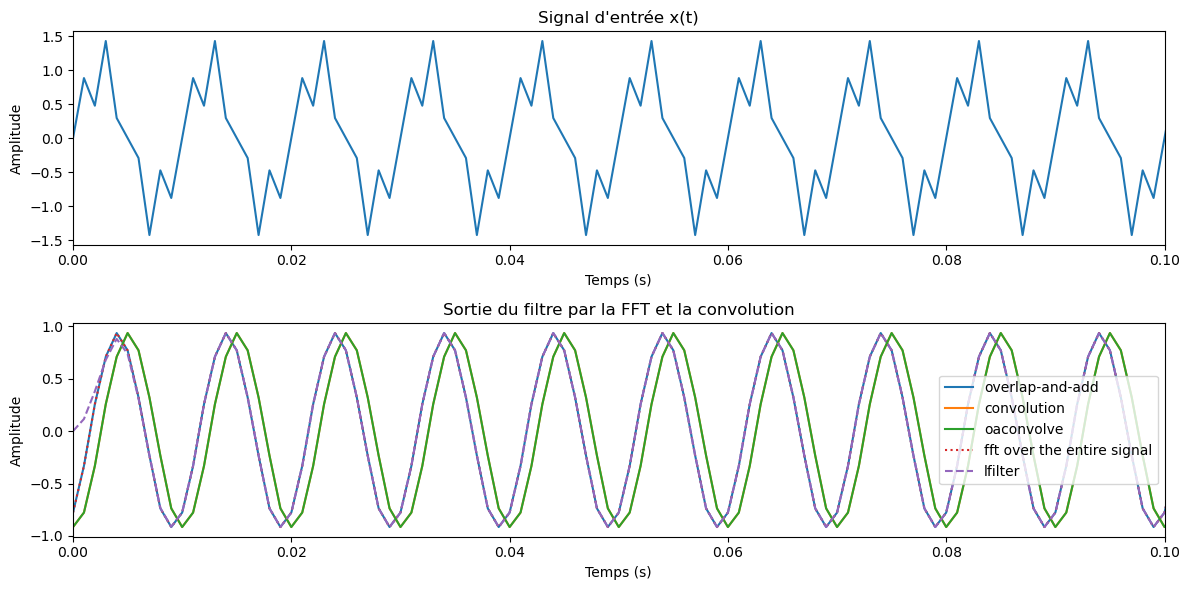

In [157]:
filterType = "Butterworth" # Concevoir un filtre Butterworth
filterOrder = 3  # Choisir un ordre de filtre approprié
cutoffFrequency = 150  # Choisir une fréquence de coupure appropriée
samplingFrequency = 1000  # Choisir une fréquence d'échantillonnage appropriée
t = np.arange(0, 1, 1/samplingFrequency)
inputSignal = np.sin(2 * np.pi * 100 * t) + 0.5 * np.sin(2 * np.pi * 400 * t)

he, b, a = create_filter(filterType, filterOrder, cutoffFrequency, samplingFrequency, 'lowpass')

# Appliquer le filtre à l'entrée x
debut = time.perf_counter()
output = applyFilter(inputSignal, he, 50, 5)
fin = time.perf_counter()
duree_execution = fin - debut
print(f"La fonction overlap-add a pris {duree_execution} secondes pour s'exécuter.")

output_oa, output_ifft, output_conv, output_lfilter = applyFilter2(inputSignal, he, b,a)

# Visualiser les résultats
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, inputSignal)
plt.title('Signal d\'entrée x(t)')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.xlim([0,0.1])

plt.subplot(2, 1, 2)
plt.plot(t, np.real(output), label = "overlap-and-add")
plt.plot(t, np.real(output_conv), label = "convolution")
plt.plot(t, np.real(output_oa), label = "oaconvolve", linestyle = "-")
plt.plot(t, np.real(output_ifft), label = "fft over the entire signal", linestyle = ":")
plt.plot(t, np.real(output_lfilter), label = "lfilter", linestyle = "--")
plt.title('Sortie du filtre par la FFT et la convolution')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim([0,0.1])


plt.tight_layout()
plt.show()

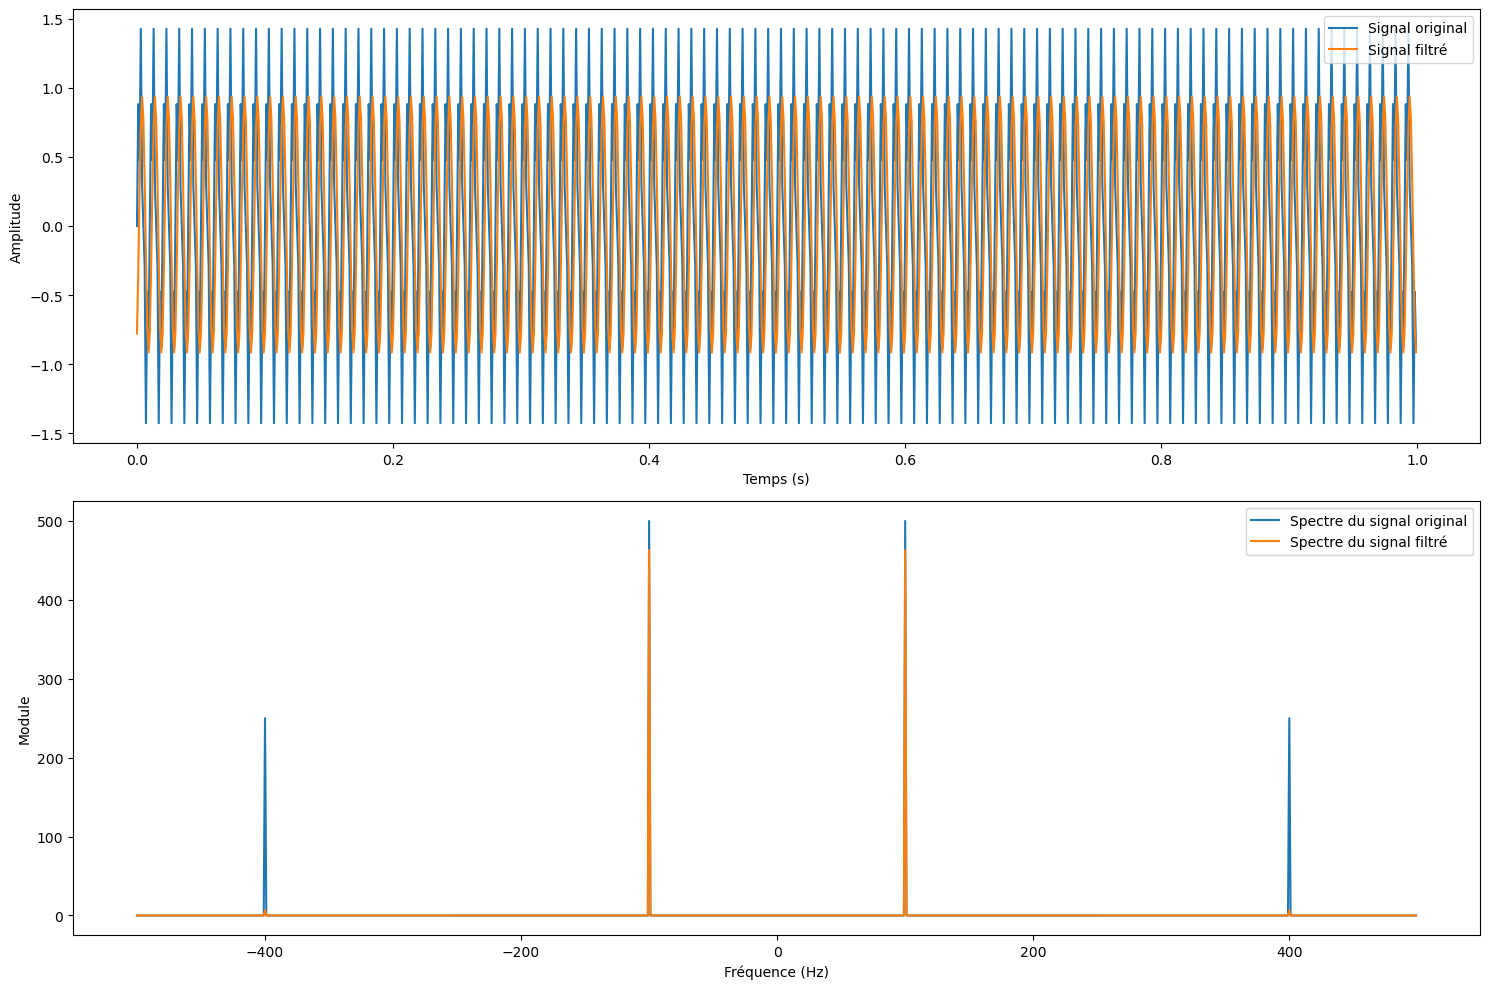

In [158]:
plot_spectre(inputSignal, samplingFrequency, output, "no", False)

## Application sur un signal audio

Le signal audio de référence est donné dans le dossider *data*. Commencez par l'écouter en l'ouvrant avec votre lecteur préféré...

Chargeons ensuite ce signal dans Python et appelons la fonction qui nous permet de rapidement afficher le signal en temporel et le module de son spectre.

Par rapport aux différences de temps d'execution entre les différentes fonctions, voyez-vous d'autres conclusions pour un signal plus complexe par rapport a l'application sur le signal simple ?

La fonction overlap-add a pris 0.13160340000013093 secondes pour s'exécuter.
La fonction signal.oaconvolve a pris 0.038236500000039086 secondes pour s'exécuter.
La fonction np.ifft sans diviser le signal a pris 1.0479230999999345 secondes pour s'exécuter.
La fonction signal.lfilter a pris 0.009457199999815202 secondes pour s'exécuter.
La fonction np.convolve a pris 0.0485473999997339 secondes pour s'exécuter.


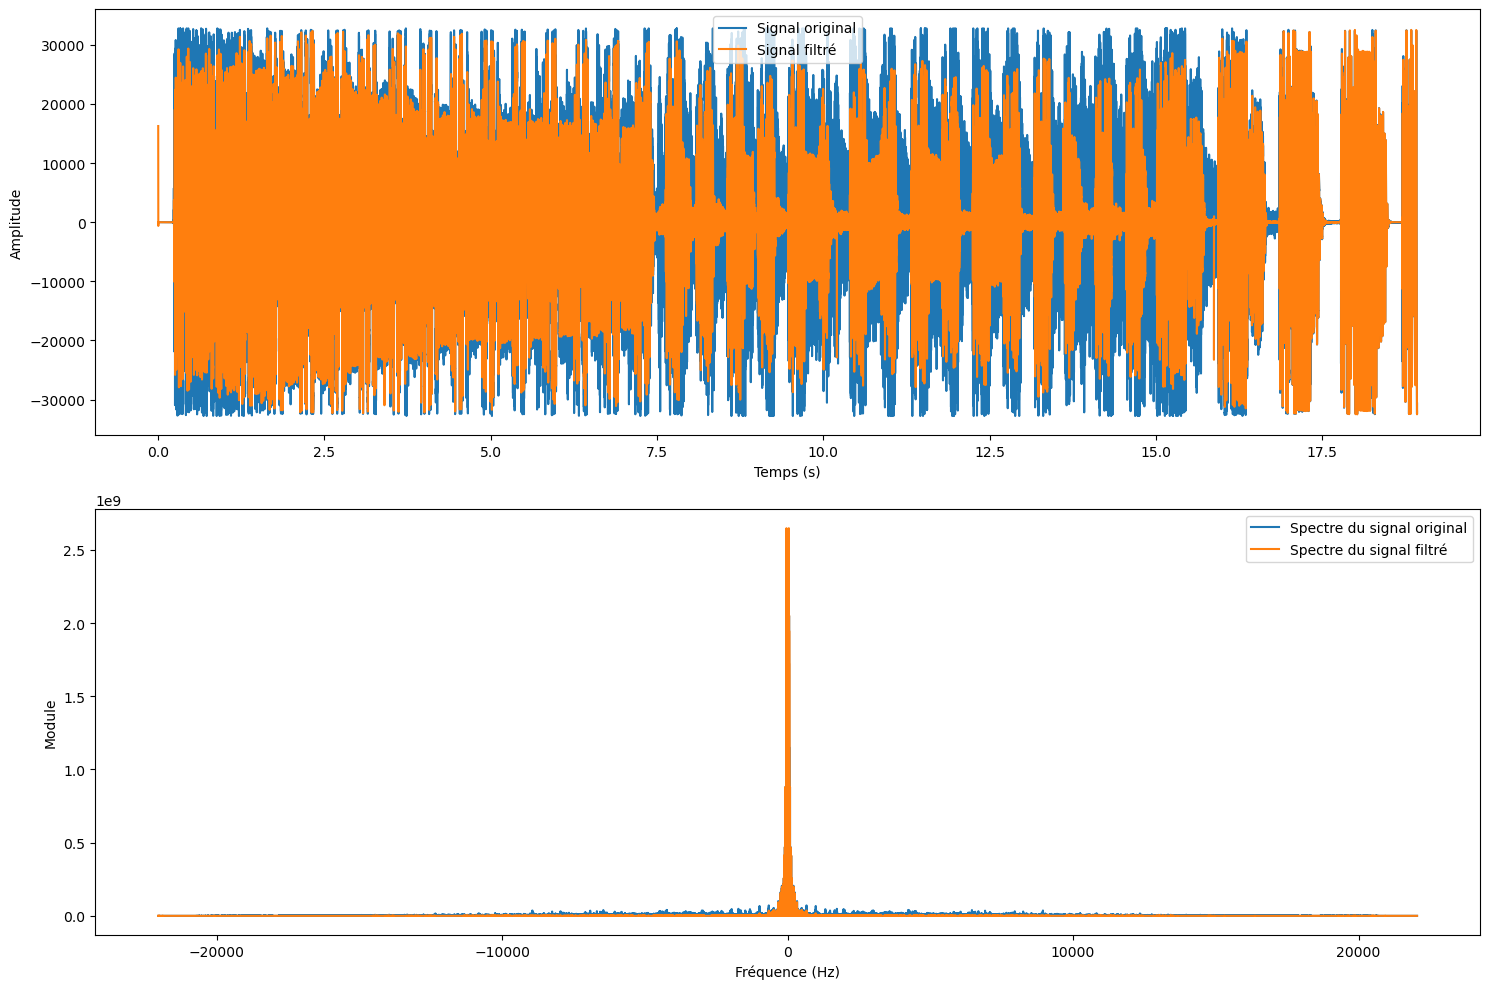

In [159]:
fech, x = read("data/sound.wav") # Music: https://www.purple-planet.com
he, b, a = create_filter('Butterworth',3,500,fech,'lowpass')
# Appliquer le filtre à l'entrée x
# Les paramètres SegmentSize et overlap sont importants et doivent être choisis avec reflexion. 
# Vous pouvez les faire varier et en observer les conséquences si vous le désirer.
debut = time.perf_counter()
output = applyFilter(x, he, 50000, 0) 
fin = time.perf_counter()
duree_execution = fin - debut
print(f"La fonction overlap-add a pris {duree_execution} secondes pour s'exécuter.")
output_oa, output_ifft, output_conv, output_lfilter = applyFilter2(x, he, b, a)

plot_spectre(x,fech, output, "no", False)
# Enregistrement du son pour vous permettre d'écouter les effets du filtrage passe-bas
write("data/sortie.wav",fech,np.asarray(np.real(output), dtype=np.int16)) 


Si tout s'est déroulé correctement, vous pouvez maintenant écouter le son filtré dans les fichiers `sortie.wav` ainsi obtenu à l'aide de votre lecteur préféré. En outre, observez les spectres affichés ci-dessus. Correspondent-ils à vos attentes pour un filtrage passe-bas, passe-haut ou passe-bande, avec les fréquences de coupure spécifiées ? N'hésitez pas à expérimenter avec les paramètres des filtres (ordre, fréquence de coupure) pour observer les changements dans les résultats ainsi que pour la méthode "overlap-add", testez différentes tailles de segments ainsi que taille d'overlap.

Aussi, vous pourrez remarquer que le gain de temps entre la division du signal ou non pour y appliquer la fft et l'ifft n'est vraiment utile que lorsqu'on a un signal plus long ou le découpage est bénéfique. Mais pas de panique si votre fonction est plus lente que les autres ! Pour diminuer son temps d'exécution, vous pouvez essayer d'optimiser votre code et faire varier les paramètres segmentSize et overlap.